Source Extraction for GALEX 

Image segmentation for point sources and sections of extended sources
Hexbin for source density and grouping with DBSCAN to ID extended sources. Extended source masks produced via a convex hull.  

In [1]:
from photutils.segmentation import detect_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import SourceCatalog
from photutils.segmentation import deblend_sources
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DBSCANGroup
from astropy.table import QTable, Table, Column 
import numpy.ma as ma 
from matplotlib.path import Path
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import sys
import time
import os
import warnings

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [ ]:
%matplotlib notebook

eclipse = "23532"
band = "NUV"

img = get_image_file(eclipse,band)

exptime = calc_exp_time(eclipse, band)
      
seg_cat, seg_image, extended_source_mask  = get_sources(img/exptime)
    
# plotting image and mask
plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99.5)),interpolation='none')
for index, point in seg_cat.dropna().iterrows():
    xypos = np.transpose([point['xcentroid'], point['ycentroid']])
    if point["extended_source"] == 0: 
        method = "white"
    else: 
        method = 'red'
    method_r = point['equivalent_radius']
    ap = CircularAperture(xypos, r=method_r)
    ap.plot(color=method, lw=.75)

In [ ]:
plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99.5)),interpolation='none')


In [2]:
def get_sources(cnt_image):
    
    extended_source_mask = extended_sources(cnt_image)

    seg_cat, seg_image = image_segmentation(cnt_image, extended_source_mask)
    
    
    return seg_cat, seg_image, extended_source_mask 


In [3]:
def extended_sources(cnt_image):
    """Location of cells within cnt image with values above thresholdCounts
    are binned and high density bins within a distance (crit_sep) of each
    other are grouped by DBSCAN. Groups of more than three are extended objects,
    and a mask is made for all extended objects. Cell values of the mask are the 
    extended object's ID for the eclipse."""
    
    thresholdCounts = 0.0006
    pixelsAboveThresh = np.where(cnt_image>thresholdCounts)

    grd = 50 # number of bins on x axis for hexbinning 
    
    dense_hexbins = plt.hexbin(pixelsAboveThresh[1],
                    pixelsAboveThresh[0],
                    gridsize=grd,
                    linewidths=0,
                    alpha=0.5,
                    cmap="viridis_r",
                    mincnt = 1000)
    plt.close()

    hexbin_centers = dense_hexbins.get_offsets() # hexbin centers
    # arr = counts.get_array().data # hexbin counts

    dense_bins = Table() # DBSCAN needs astropy table
    dense_bins['x_0'] = hexbin_centers[:,0]
    dense_bins['y_0'] = hexbin_centers[:,1]

    imageSize = cnt_image.shape
    
    # max distance between pts to be in same group 
    crit_sep = round(imageSize[0] / grd)

    # DBSCAN needs at least 1 input, but realistically I want a group of at least 3 dense bins
    if len(dense_bins) < 3: 
        return np.full(imageSize, 0) 
    
    # grouping based on distance between points (crit_separation)
    dbscan_group = DBSCANGroup(crit_separation=crit_sep*2) 
    extendedObjects = dbscan_group(dense_bins)
    extendedObjects = extendedObjects.group_by('group_id')


    mask = np.full(imageSize, 0) 
    objID = 1 
    for i, group in enumerate(extendedObjects.groups):
        if len(group) > 3:
            newMask = get_hull_mask(group, objID, imageSize, crit_sep)
            mask = np.add(mask,newMask) 
            objID += 1        

    return mask

In [4]:
def image_segmentation(cnt_image, extended_source_mask): 
    
    # estimate and subtract the background
    bkg_estimator = MedianBackground()
    bkg = Background2D(cnt_image, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)
    cnt_image -= bkg.background 
    
    # define detection threshold (this is a 2D detection threshold
    # image made w/ background RMS image, 1.5 sigma per pixel 
    # noise level)
    threshold = 1.5 * bkg.background_rms

    # convolve the cnt image 
    kernel = make_2dgaussian_kernel(3, size=(3,3))# FWHM = 3.
    convolved_data = convolve(cnt_image, kernel)
    
    # segment image and deblend sources 
    segment_map = detect_sources(convolved_data,
                                 threshold,
                                 npixels=5)

    deblended_seg_map = deblend_sources(convolved_data,
                                       segment_map,
                                       npixels=8,
                                       nlevels=20,
                                       contrast=0.002,
                                       mode = 'linear',
                                       progress_bar=False)
                                       # mode used to be exponential, but was changing to linear midway

    # use segmentation map to make catalog w morpholgoy info, columns are info we want in catalog
    # can add more columns w/ outputs listed in photutils image seg documentation
    columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux',
               'elongation','eccentricity', 'equivalent_radius', 'orientation',
               'max_value','maxval_xindex','maxval_yindex','min_value',
               'minval_xindex','minval_yindex','bbox_xmin','bbox_xmax',
               'bbox_ymin','bbox_ymax']
    
    matched = list(np.stack((deblended_seg_map,extended_source_mask),axis=2).flatten())
    iterator = iter(matched)
    matches = set(list(zip(iterator, iterator)))
    # in matches, first tuple val is seg map and second is extended source

    cat = SourceCatalog(cnt_image, 
                        deblended_seg_map, 
                        convolved_data=convolved_data)
        
    seg_sources = cat.to_table(columns=columns).to_pandas()

    seg_sources = seg_sources.set_index(seg_sources["label"])
    
    # default to not in extended source
    seg_sources["extended_source"] = 0 
 
    for i in matches: 
        seg_sources.loc[i[0],"extended_source"] = i[1] 
    
    return seg_sources, deblended_seg_map

In [5]:
def get_hull_mask(group, objID, imageSize, critSep):
    """calculates convex hull of pts in group and uses Path to make a mask of 
    each convex hull, assigning a number (objID) to each hull as they are made"""
    
    xypos = np.transpose([group['x_0'], group['y_0']])
    hull = ConvexHull(xypos)

    hullVerts = tuple(zip(xypos[hull.vertices,0], xypos[hull.vertices,1]))

    ny, nx= imageSize
    
    poly_path=Path(hullVerts)

    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    hull_mask = poly_path.contains_points(points,radius=critSep*1.5) # radius adds a small buffer area to the mask
    hull_mask = hull_mask.reshape((ny,nx))
    hull_mask = hull_mask.astype(int)*objID
    
    return hull_mask

In [6]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

def calc_exp_time(eclipse, band):
    """sums frame exposure times in exp time csv output by pipeline """
    from os.path import exists
    if band == "FUV":
        b = "fd"
    else:
        b = "nd"
    if exists(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv"):
        exp_time = pd.read_csv(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv")
        tot_exp_time = sum(exp_time["expt"])
    return tot_exp_time

def get_image_file(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/exploration_notebooks/test_data/miniCat', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    # masking cnt image
    
    #print(cnt.shape)
    
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

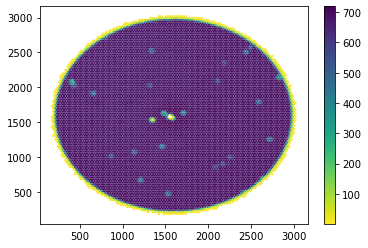

In [59]:
eclipse = "17079"
band = "NUV"

img = get_image_file(eclipse,band)

exptime = calc_exp_time(eclipse, band)

cnt_image = img/exptime

thresholdCounts = 0.001
pixelsAboveThresh = np.where(cnt_image>thresholdCounts)

grd = 100 # number of bins on x axis for hexbinning 

plt.hexbin(pixelsAboveThresh[1],
                    pixelsAboveThresh[0],
                    gridsize=grd,
                    linewidths=0,
                    cmap="viridis_r",
                    mincnt = 1)
plt.colorbar()

In [ ]:
plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99.5)),interpolation='none')
plt.colorbar()

In [ ]:
# options for variables 
grid_sizes = [20, 30, 40, 50]
min_cnts = [200, 500, 800, 1200]

# eclipses to look at 
eclipses = ["14932","08556","17079","00781","02575","03239","23532",'04644','13858','15119','29216']
bands = ["NUV","FUV"]


for eclipse in eclipses: 
    
    for band in bands: 
        
        fig1 = plt.figure()
        chrt = 0
        
        img = get_image_file(eclipse,band)

        exptime = calc_exp_time(eclipse, band)

        cnt_image = img/exptime

        for i in range(4): 

            for b in range(4):
                chrt += 1 

                thresholdCounts = 0.006
                pixelsAboveThresh = np.where(cnt_image>thresholdCounts)

                grd = grid_sizes[i] # number of bins on x axis for hexbinning 

                ax = fig1.add_subplot(4,4, chrt)
                plt.hexbin(pixelsAboveThresh[1],
                                pixelsAboveThresh[0],
                                gridsize=grd,
                                linewidths=0,
                                cmap="viridis_r",
                                mincnt = min_cnts[b])
                plt.title(f"Grid {grid_sizes[i]}, min count {min_cnts[b]}",fontsize=6, pad=2)
                cbar = plt.colorbar()
                cbar.ax.tick_params(labelsize=6) 
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                
        fig1.suptitle(f"Eclipse {eclipse}, {band}, count threshold {thresholdCounts}", fontsize=10)
        plt.savefig(f'e{eclipse}_{band}_thresh{thresholdCounts}.png')
        plt.close()

In [ ]:

# eclipses to look at 
eclipses = ["14932","08556","17079","00781","02575","03239","23532",'04644','13858','15119','29216']
bands = ["NUV","FUV"]


for eclipse in eclipses: 
    
    for band in bands: 
        
        img = get_image_file(eclipse,band)

        exptime = calc_exp_time(eclipse, band)

        cnt_image = img/exptime
        
        plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)))
        plt.savefig(f"e{eclipse}_{band}_expt_{exptime}.png")